In [1]:
import numpy as np
import pandas as pd
import pandas_ta
# import ta
import yfinance as yf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
import datetime as dt

import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm
tqdm.pandas()

%config InlineBackend.figure_format = 'retina'

In [2]:
symbols_list = ['AAPL', 'NVDA', 'TXG', 'TLSA', 'META', 'AMD', 'MSFT', 'GOOGL', 'TSM']

In [3]:
# end_date = '2024-08-02'
end_date = dt.datetime.today()
start_date = pd.to_datetime(end_date) - pd.DateOffset(365*100)

In [4]:
df = yf.download(symbols_list,
                 start=start_date,
                 end=end_date, threads=True).stack()
df.index.names = ['date', 'ticker']
df.columns = df.columns.str.lower()
df.columns.name = None

[*********************100%%**********************]  9 of 9 completed


In [5]:
aapl_df = df.query('ticker == "AAPL"').copy()
aapl_df.rename(columns={'adj close': 'adj_close'}, inplace=True)
aapl_df = aapl_df.reset_index(level=1)
aapl_df = aapl_df.asfreq('B').ffill()

In [6]:
aapl_df['ret'] = aapl_df.adj_close.pct_change().pipe(lambda x: x.clip(lower=x.quantile(0.005), upper=x.quantile(1-0.005)))

# aapl_df['ret'] = aapl_df.adj_close.apply(np.log).diff().pipe(lambda x: x.clip(lower=x.quantile(0.005), upper=x.quantile(1-0.005)))
# aapl_df['1w_ma'] = aapl_df.adj_close.apply(np.log1p).rolling(5).mean().transform(lambda x: (x-x.mean())/x.std())
# aapl_df['1m_ma'] = aapl_df.adj_close.apply(np.log1p).rolling(20).mean().transform(lambda x: (x-x.mean())/x.std())
# aapl_df['1q_ma'] = aapl_df.adj_close.apply(np.log1p).rolling(20 * 3).mean().transform(lambda x: (x-x.mean())/x.std())
aapl_df['rsi'] = pandas_ta.rsi(aapl_df['adj_close'], length=10)
aapl_df['macd'] = pandas_ta.macd(close=aapl_df['adj_close'], length=10).iloc[:,0].transform(lambda x: (x-x.mean())/x.std()).pipe(lambda x: x.clip(lower=x.quantile(0.005), upper=x.quantile(1-0.005)))
aapl_df['garman_klass_vol'] = ((np.log(aapl_df['high']) - np.log(aapl_df['low']))**2)/2-(2*np.log(2)-1)*((np.log(aapl_df['adj_close']) - np.log(aapl_df['open']))**2)

In [7]:
def compute_atr(data):
    atr = pandas_ta.atr(high=data['high'],
                        low=data['low'],
                        close=data['adj_close'],
                        length=5)
    # return atr.sub(atr.mean()).div(atr.std())
    return atr
aapl_df['atr'] = compute_atr(aapl_df).transform(lambda x: (x-x.mean())/x.std())

In [8]:
compute_atr(aapl_df).transform(lambda x: (x-x.mean())/x.std())

date
1980-12-12         NaN
1980-12-15         NaN
1980-12-16         NaN
1980-12-17         NaN
1980-12-18         NaN
                ...   
2025-01-22    3.031521
2025-01-23    2.869152
2025-01-24    2.675096
2025-01-27    3.167764
2025-01-28    3.682676
Freq: B, Name: ATRr_5, Length: 11513, dtype: float64

In [9]:
aapl_df = aapl_df.dropna()

<Axes: title={'center': 'Garman Klass Volatility'}, xlabel='date'>

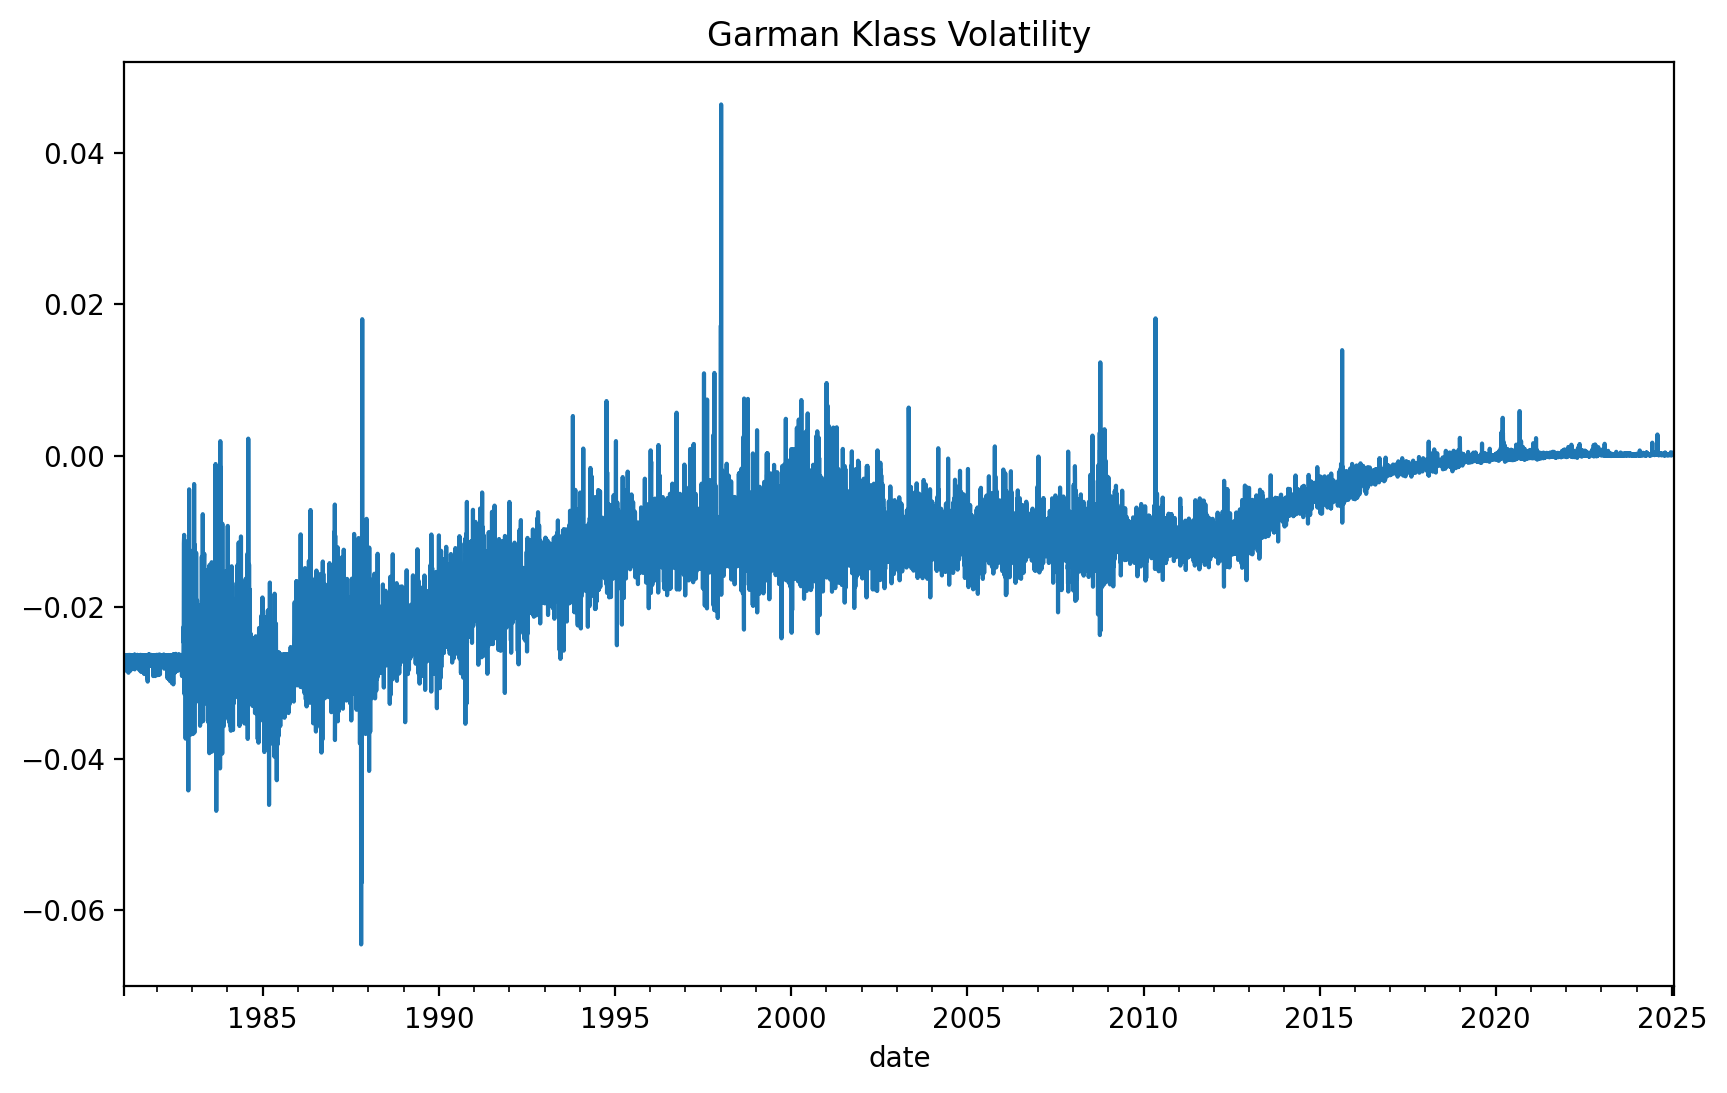

In [10]:
aapl_df['garman_klass_vol'].plot(figsize=(10, 6), title='Garman Klass Volatility')

In [11]:
# aapl_df['1w_ma'][-300:].plot(label='1 week MA')
# aapl_df['1m_ma'][-300:].plot(label='1 month MA')
# aapl_df['1q_ma'][-300:].plot(label='1 quarter MA')
# plt.legend()

<Axes: ylabel='Frequency'>

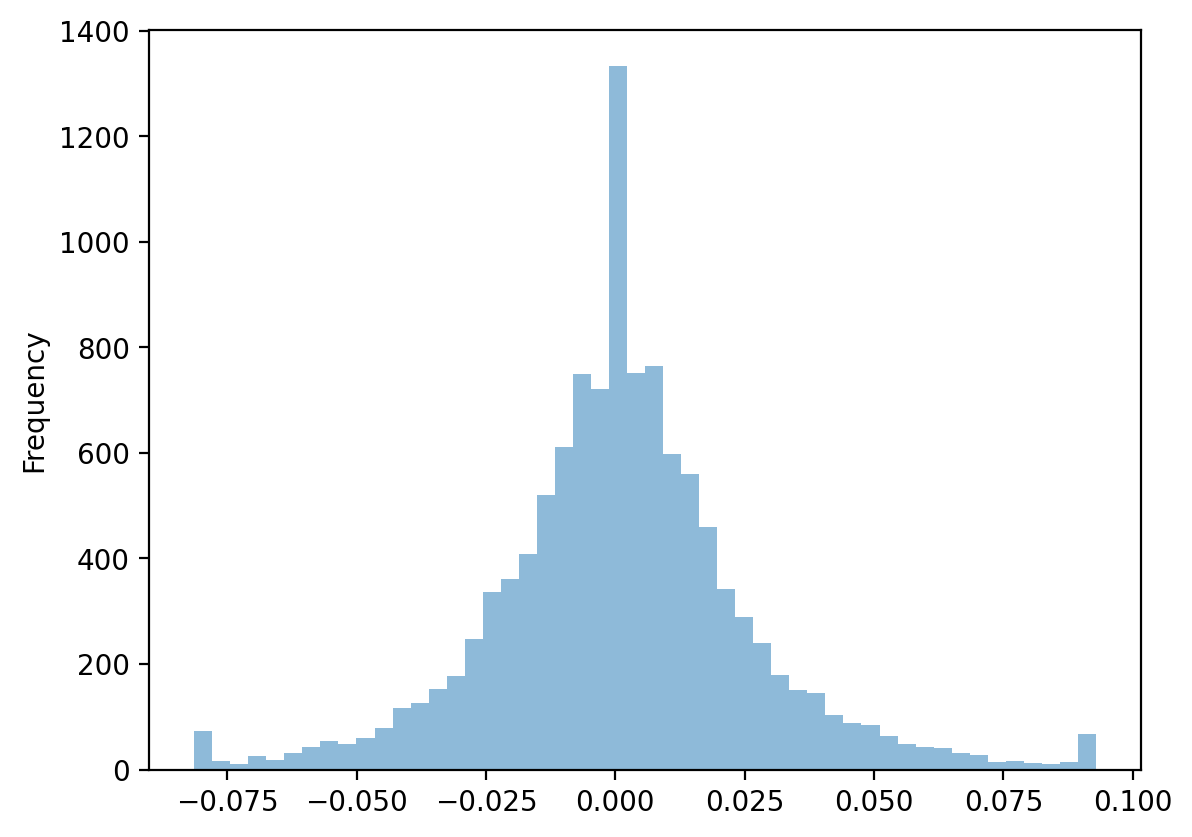

In [12]:
aapl_df['ret'].plot(kind='hist', bins=50, alpha=0.5, label='Returns')

<Axes: ylabel='Frequency'>

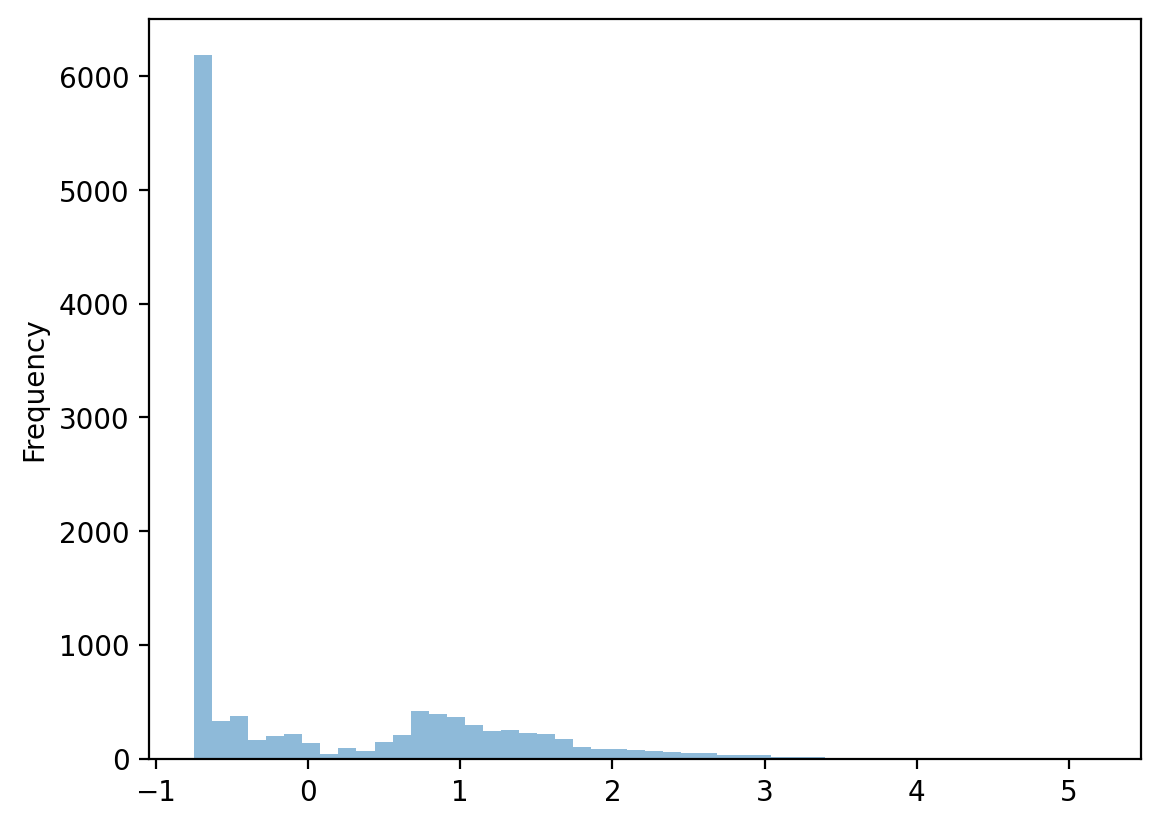

In [13]:
aapl_df['atr'].plot(kind='hist', bins=50, alpha=0.5, label='ATR')

<Axes: ylabel='Frequency'>

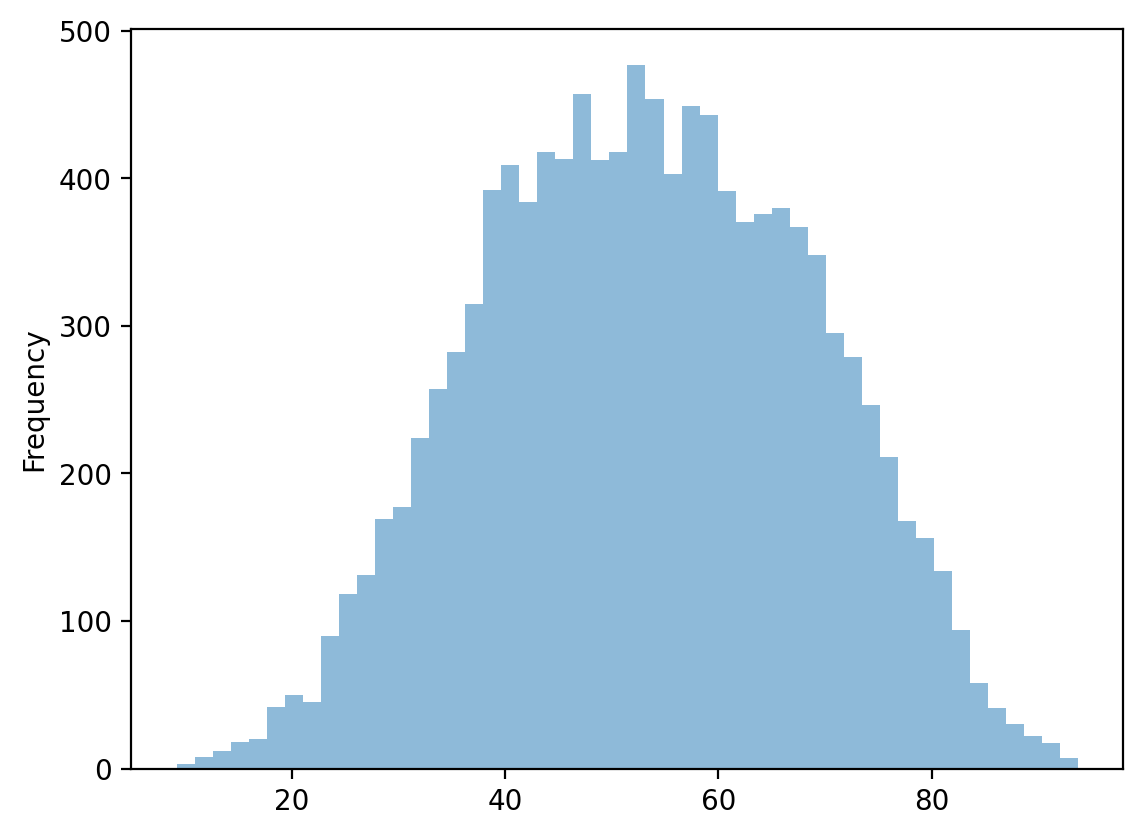

In [14]:
aapl_df['rsi'].plot(kind='hist', bins=50, alpha=0.5, label='RSI')

<Axes: ylabel='Frequency'>

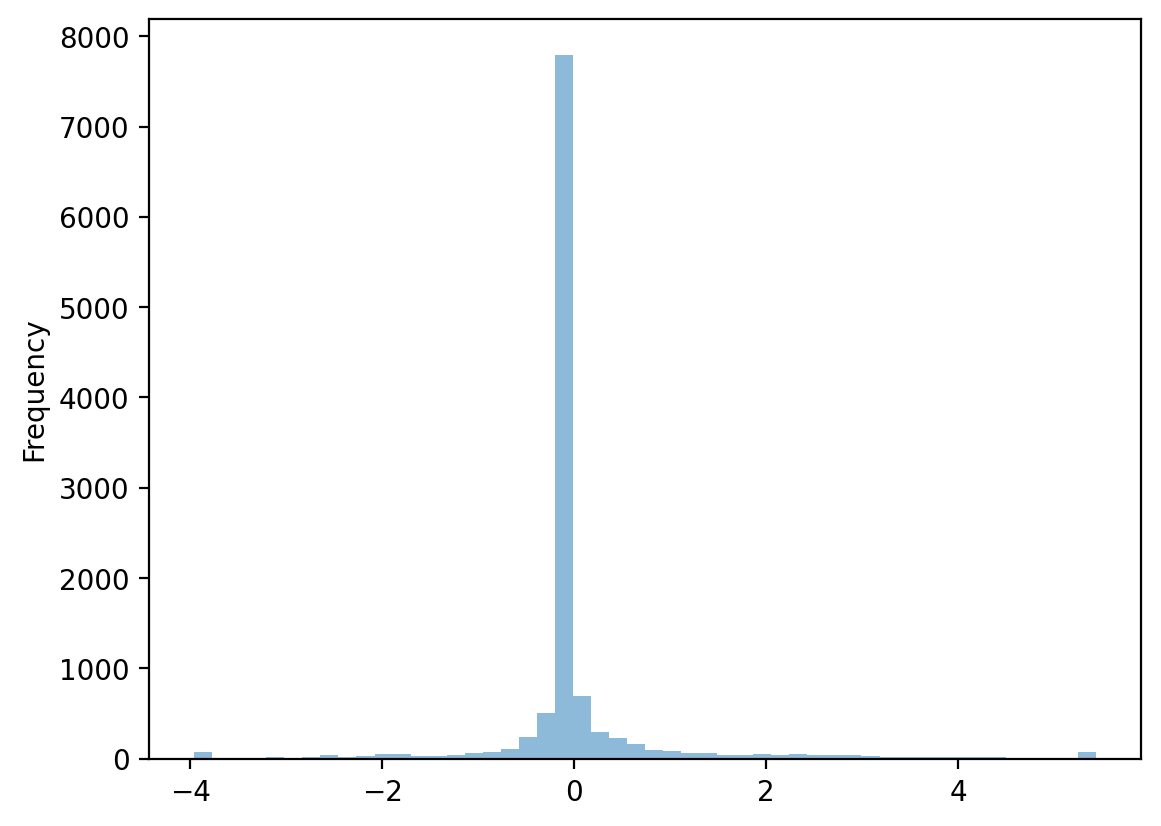

In [15]:
aapl_df['macd'].plot(kind='hist', bins=50, alpha=0.5, label='MACD')

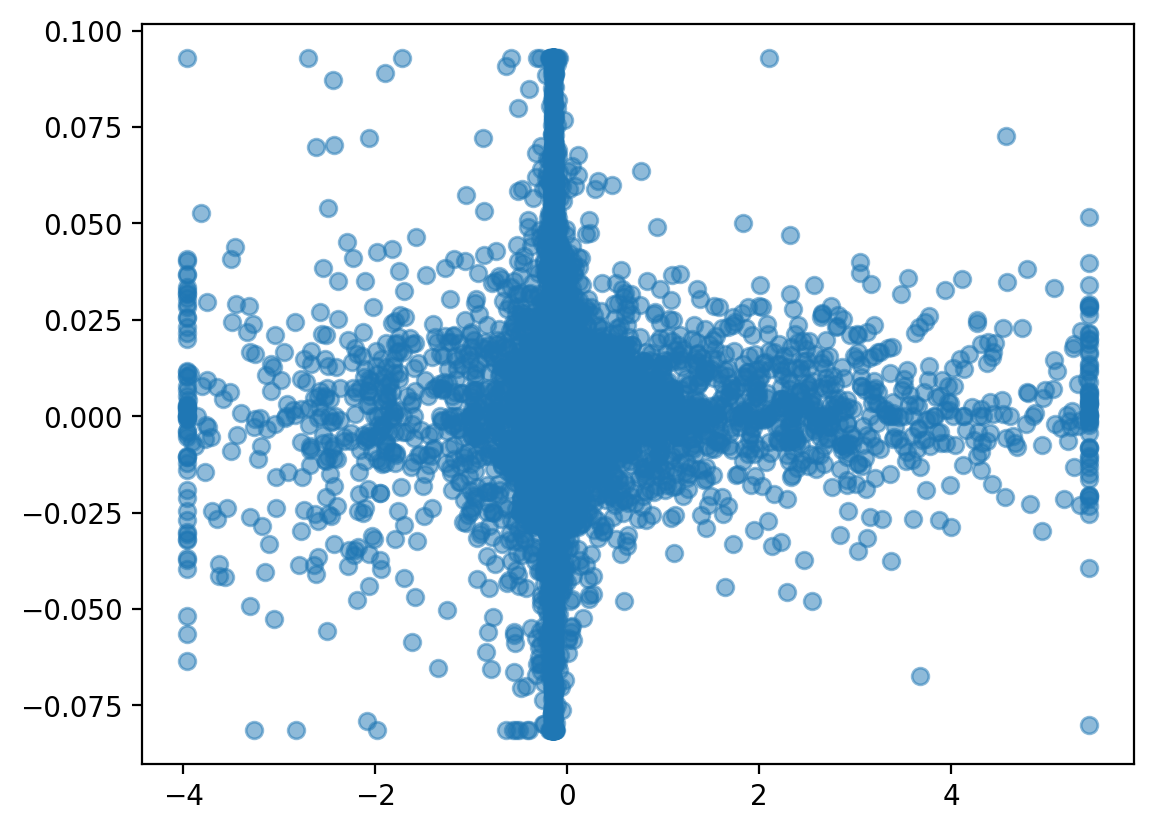

In [16]:
plt.scatter(aapl_df['macd'], aapl_df.ret, alpha=0.5)

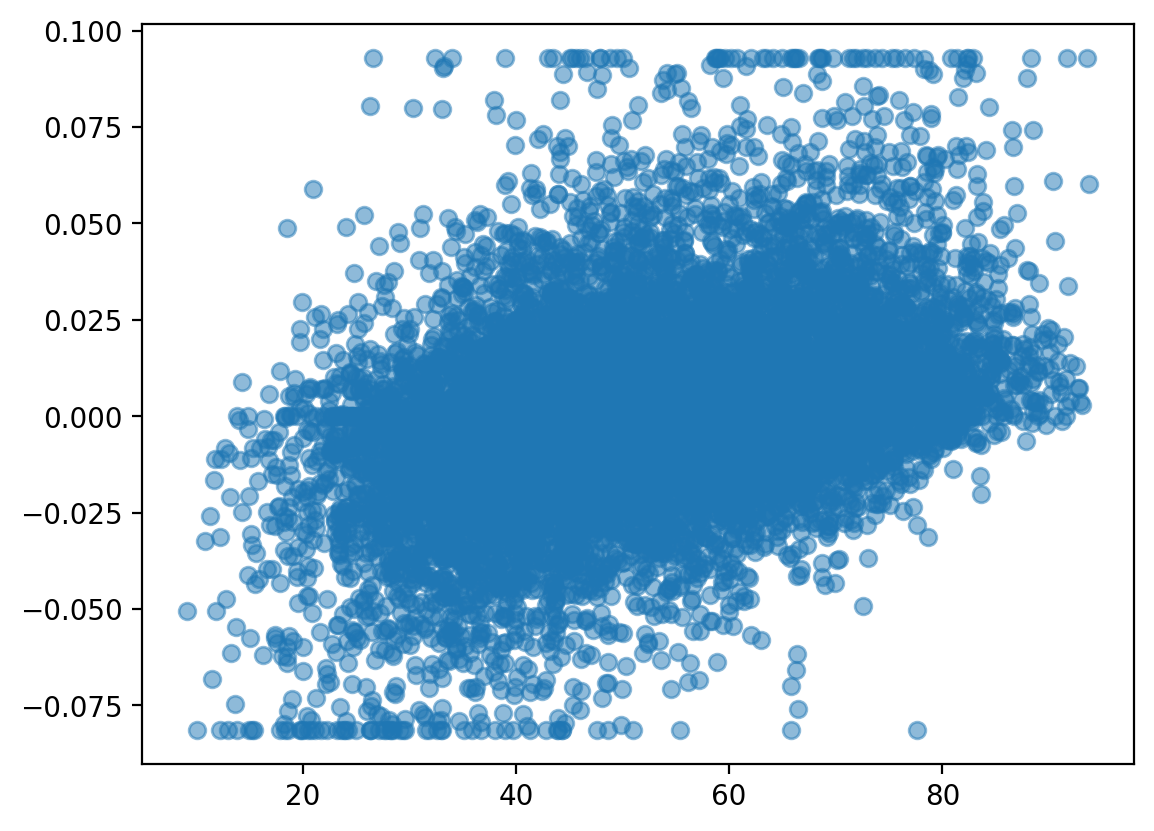

In [17]:
plt.scatter(aapl_df['rsi'], aapl_df.ret, alpha=0.5)

In [18]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    # Determing rolling statistics
    rolmean = timeseries.rolling(window=20).mean()
    rolstd = timeseries.rolling(window=20).std()

    # Plot rolling statistics:
    plt.figure(figsize=(10, 6))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

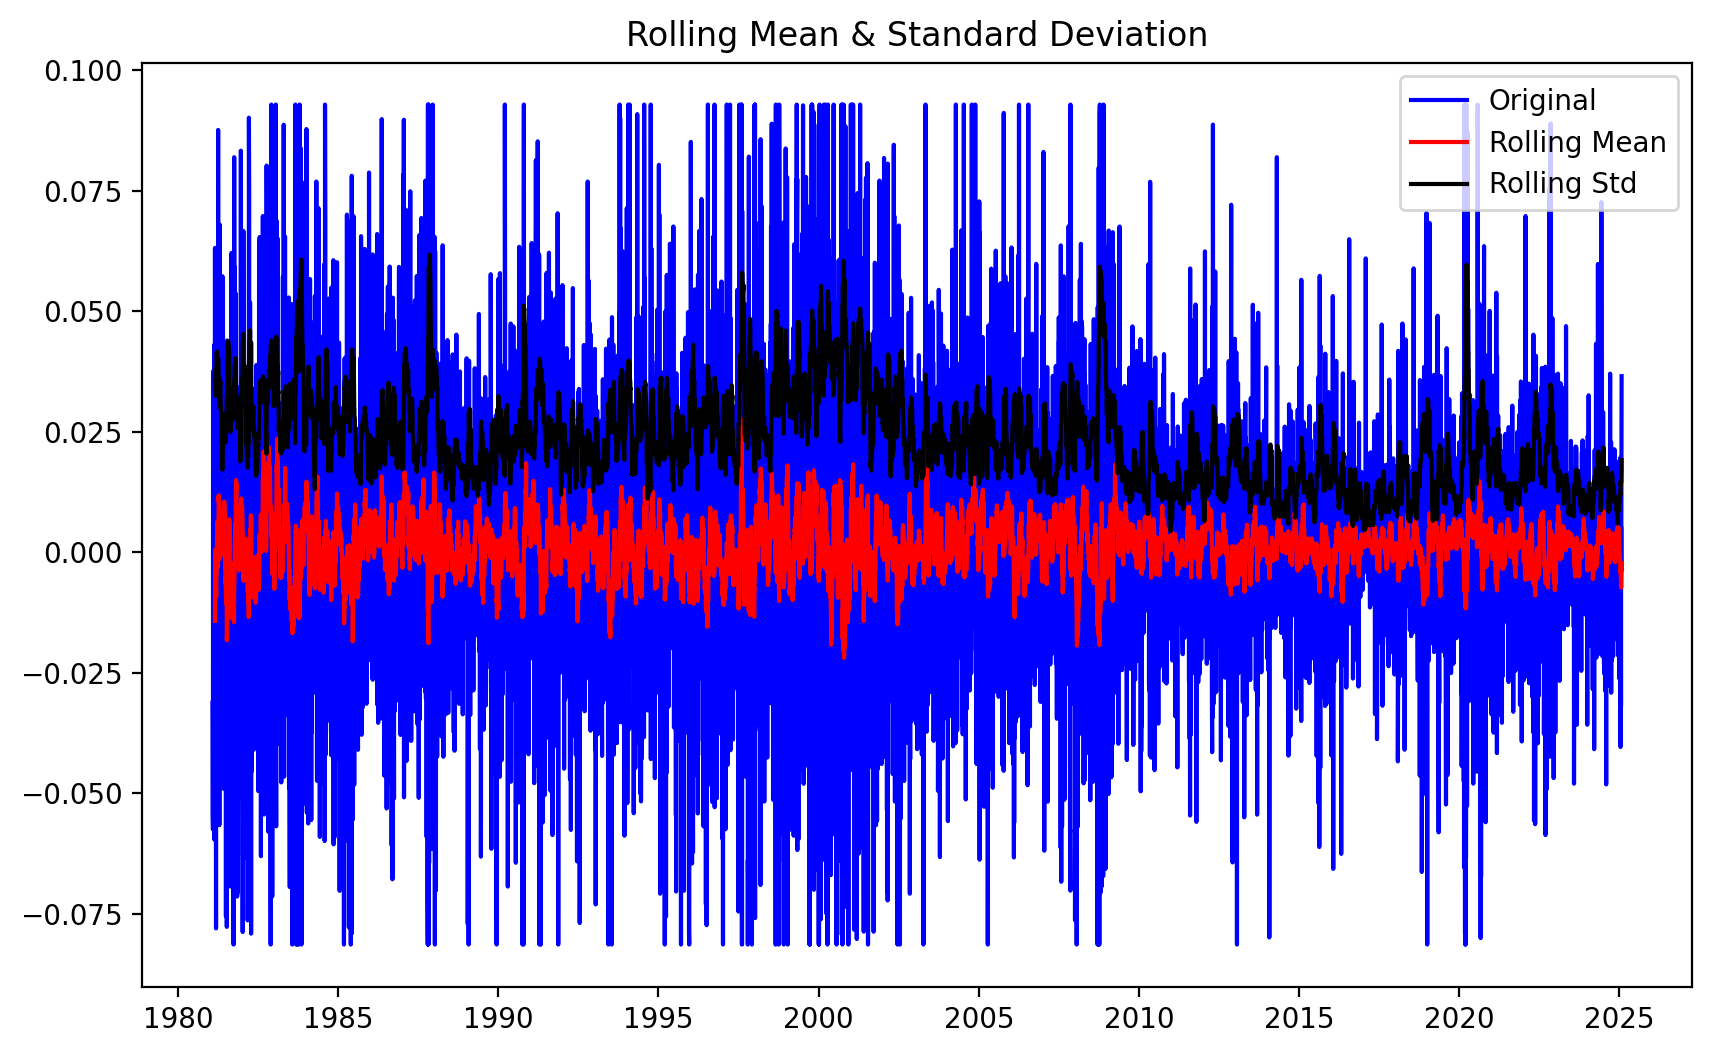

In [19]:
test_stationarity(aapl_df.ret)

In [20]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

X = aapl_df[['rsi']]
y = aapl_df['ret']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

lm = LinearRegression()
lm.fit(X_train, y_train)


epsilon = mean_absolute_error(y_train, lm.predict(X_train))
y_pred = lm.predict(X_test)


In [21]:
r2_score(y_test, y_pred)

0.053655538559146065

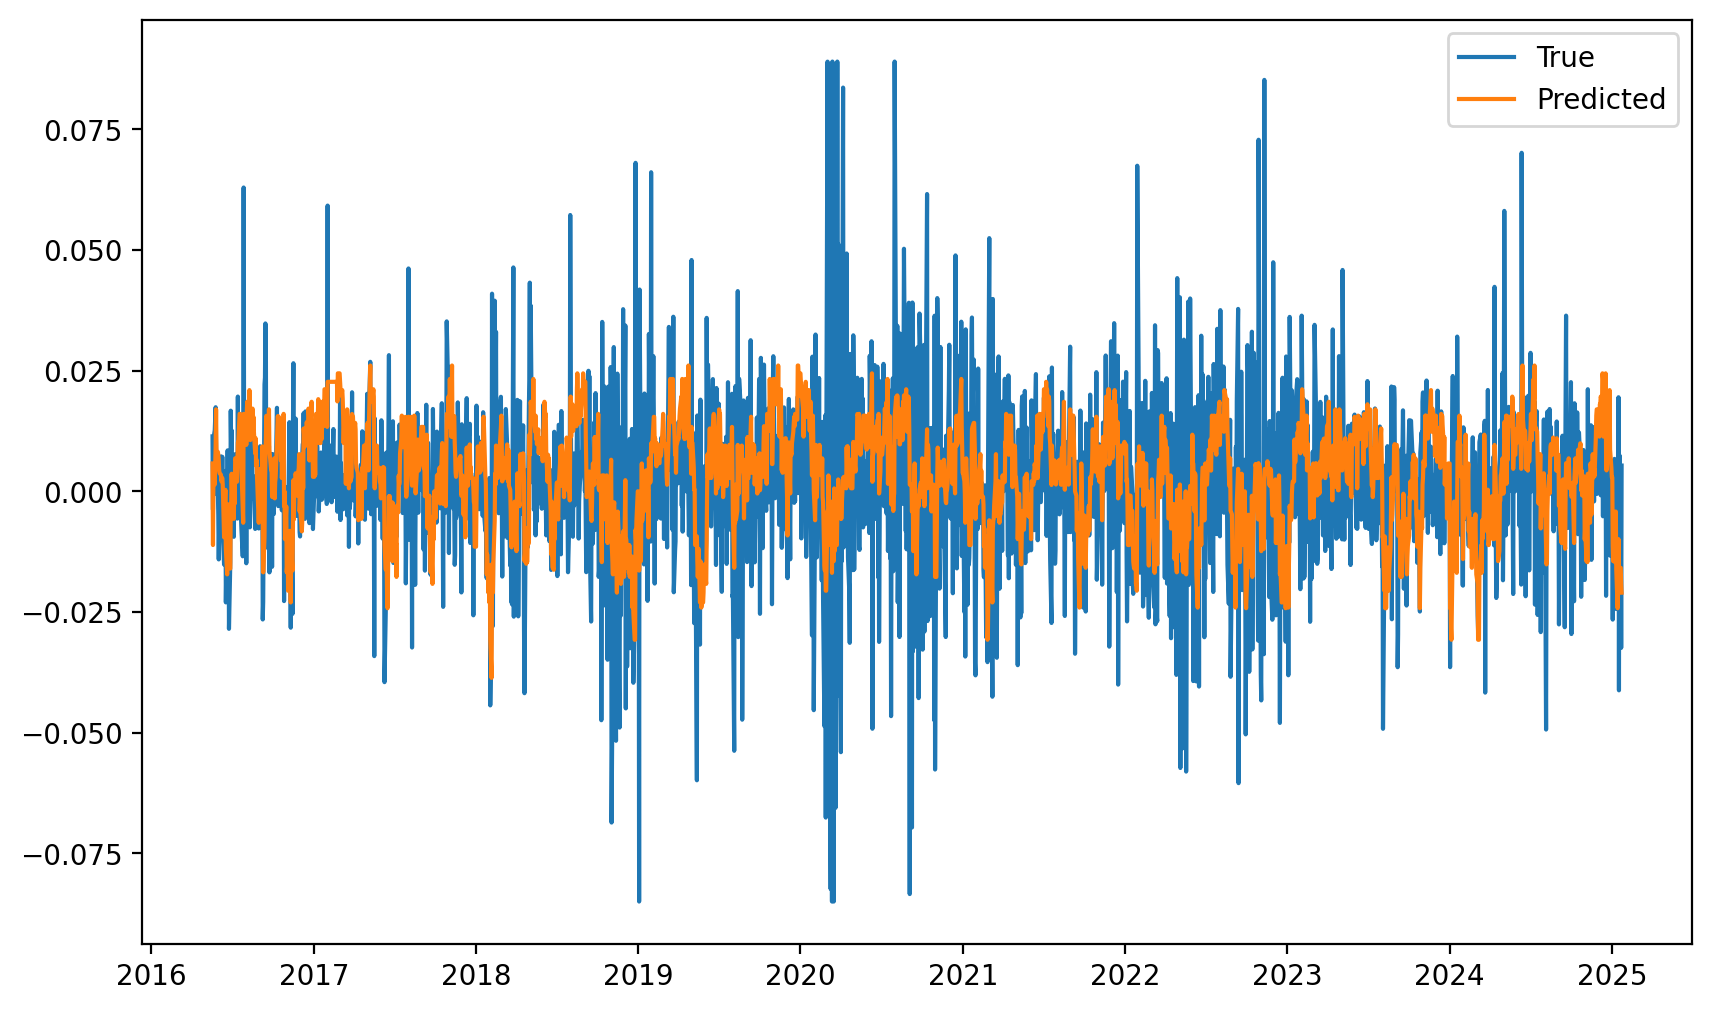

In [418]:
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test.values, label='True')
plt.plot(y_test.index, y_pred, label='Predicted')
plt.legend()

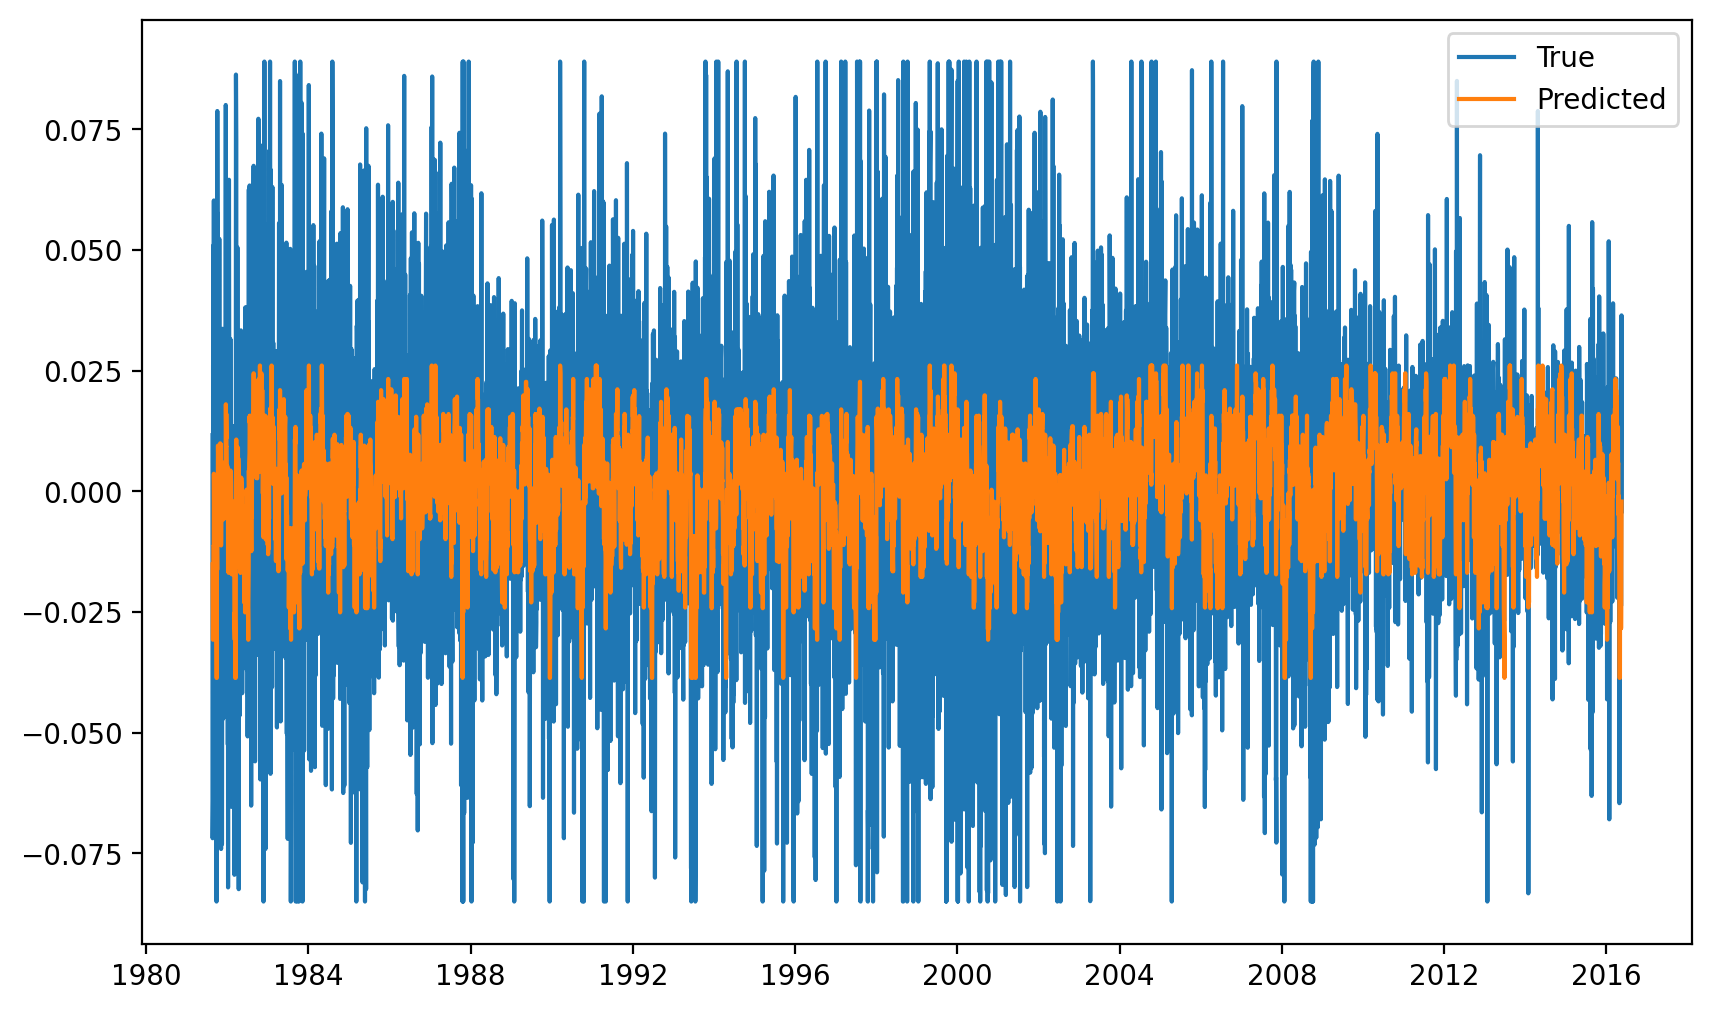

In [419]:
y_hat = lm.predict(X_train)

plt.figure(figsize=(10, 6))
plt.plot(y_train.index, y_train.values, label='True')
plt.plot(y_train.index, y_hat, label='Predicted')
plt.legend()

In [404]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(y_train, exog=X_train, order=(3, 0, 0))
results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    ret   No. Observations:                 9064
Model:                 ARIMA(3, 0, 0)   Log Likelihood               20751.395
Date:                Wed, 29 Jan 2025   AIC                         -41490.791
Time:                        10:18:54   BIC                         -41448.119
Sample:                    08-20-1981   HQIC                        -41476.276
                         - 05-17-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0349      0.001    -41.172      0.000      -0.037      -0.033
rsi            0.0007   1.61e-05     41.939      0.000       0.001       0.001
ar.L1          0.0100      0.008      1.230      0.219      -0.006       0.026
ar.L2         -0.0411      0.009     -4.820      0.000      -0.058      -0.024
ar.L3         -0.0355      0.009     -4.049      0.000      -0.053      -0.018
sigma2         0.0006    7.3e-06     82.297      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               639.52
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.61   Skew:                             0.24
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [405]:
y_pred = results.forecast(steps=len(y_test), exog=X_test)
y_pred.index = y_test.index

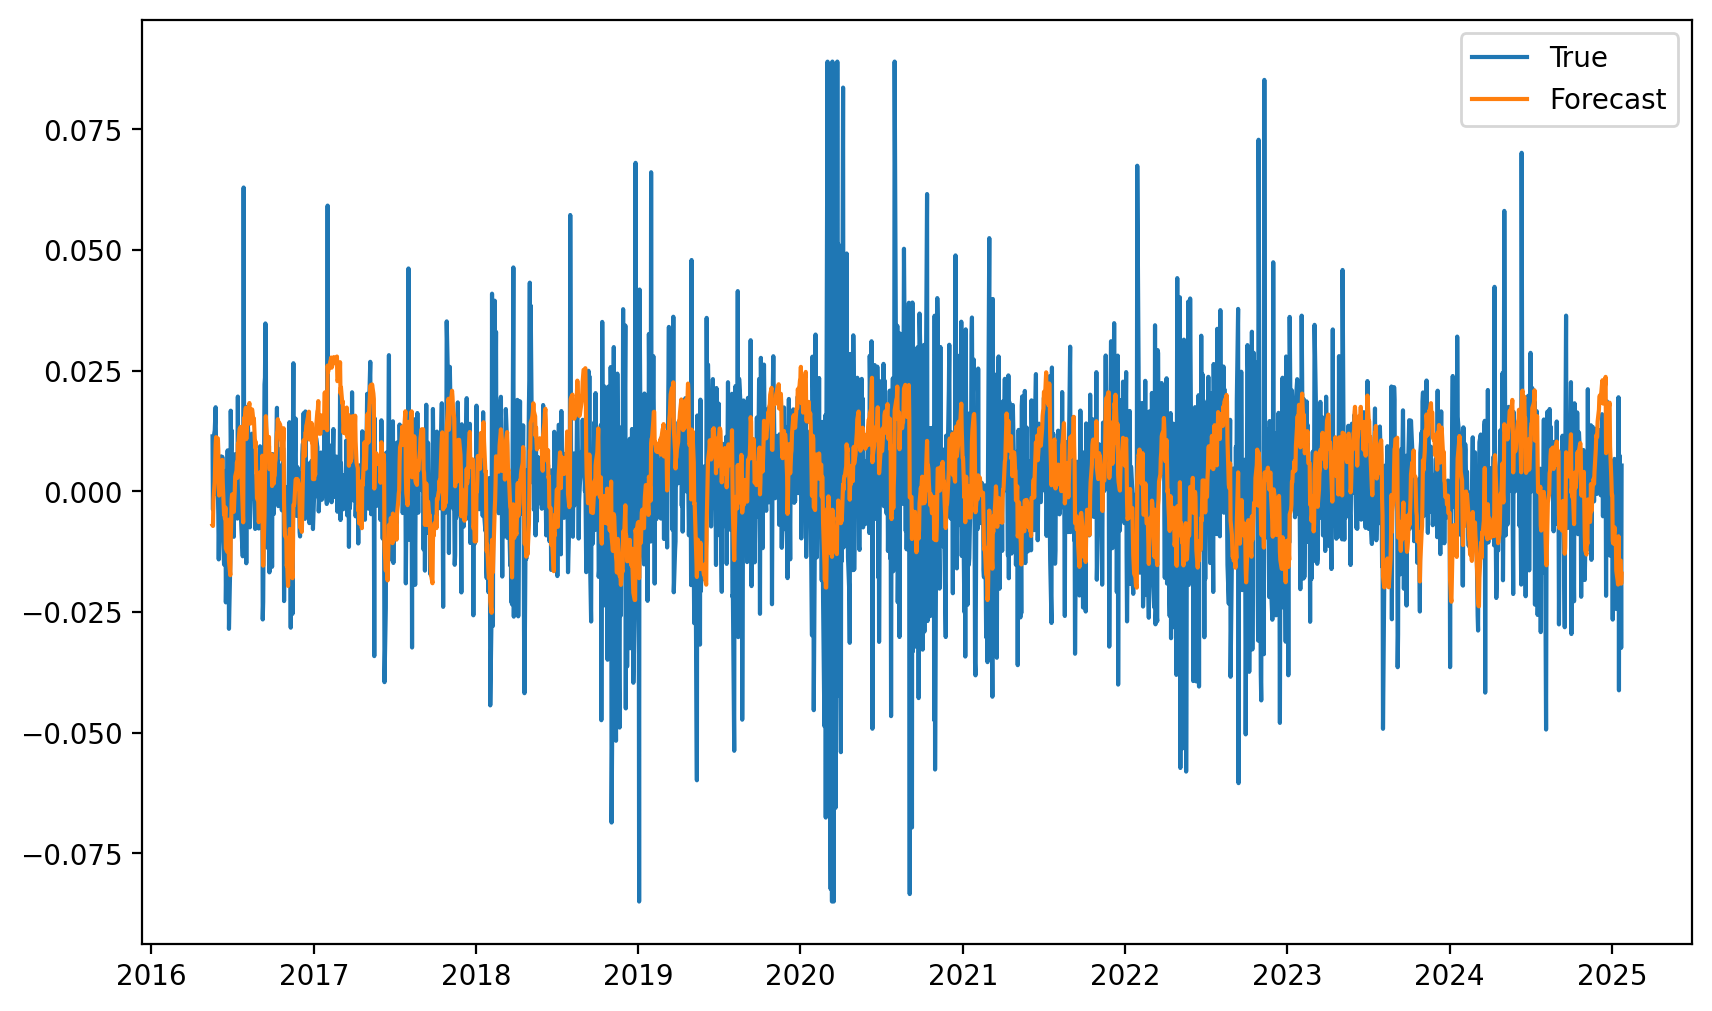

In [406]:
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test.values, label='True')
plt.plot(y_test.index, y_pred.values, label='Forecast')
plt.legend()
